# 日历效果策略


In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


工具方法

In [2]:
# %run ./shared/tools.py

from shared.tools import get_drawdown, cal_period_perf_indicator, datestr2dtdate, date_count_in_month


策略逻辑

In [3]:
def calendar_strategy(index_data, index_id, start_date, end_date, calendard_range, fee_rate):
    df = index_data.loc[start_date:end_date, [index_id]]
    df['index_ret'] = df[index_id].pct_change()
    df['index'] = (1 + df['index_ret']).cumprod()
    df['date_count_in_month'] = date_count_in_month(df.index)
    df['pos'] = [1 if (e >= calendard_range[0] and e <= calendard_range[1]) else 0 for e in df['date_count_in_month']]
    # df['pos']= df.pos.shift(-1, fill_value=0)
    df['stgy_ret'] = df['pos'] * df['index_ret']
    rebalancing_rows = df[df['date_count_in_month'] == 1].index
    df.loc[rebalancing_rows, 'stgy_ret'] = df.loc[rebalancing_rows, 'stgy_ret'] - fee_rate
    df['stgy'] = (1 + df['stgy_ret']).cumprod()
    df.fillna({'index': 1, 'stgy': 1}, inplace=True)

    # 回测结果展示
    fig = plt.figure(figsize=(16, 8))
    ax1 = fig.add_subplot(2, 1, 1)
    df.loc[:, ['index', 'stgy']].plot(ax=ax1,
                                      grid=True,
                                      title='%s: t1=%d, t2=%d' % (index_id, calendard_range[0], calendard_range[1]),
                                      legend=False)
    ax2 = fig.add_subplot(2, 1, 2)
    df.loc[:, ['pos']].plot(ax=ax2, grid=True)
    res = cal_period_perf_indicator(df.loc[:, ['index', 'stgy']])
    print(res)

设置回测参数

In [4]:
# 回测起止日期
start_date = datetime.date(2022, 1, 1)
end_date = datetime.date(2022, 12, 31)
# 每月持仓交易起始日、截止日。从1起
t1 = 1
t2 = 5
# 交易手续费
fee_rate_fund = 0.0015
fee_rate_stock = 0.00025

加载数据

In [5]:
index_data = pd.read_csv('res/指数历史数据.csv').set_index('datetime')
index_data.index = [datestr2dtdate(e) for e in index_data.index]

index_ids = ['hs300', 'csi500', 'csi1000']

回测

         AnnRet    AnnVol        SR     MaxDD    Calmar
index -0.203453  0.202452 -1.004944 -0.286526 -0.710067
stgy    0.02353  0.105003  0.224093 -0.119757  0.196485


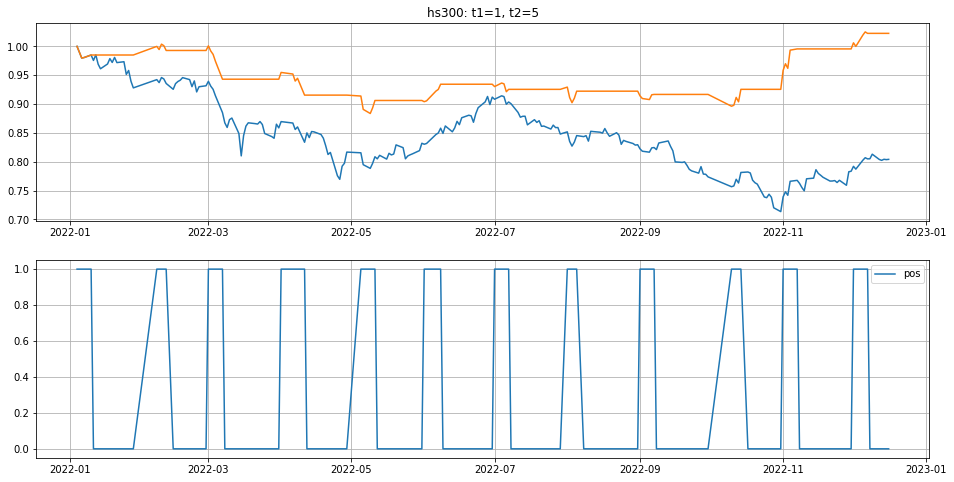

In [6]:
# 标的指数：'hs300' or 'csi500' or 'csi1000'

calendar_strategy(index_data, index_ids[0], start_date, end_date, [t1, t2], fee_rate_stock)

         AnnRet    AnnVol        SR     MaxDD    Calmar
index -0.181049  0.216699 -0.835485 -0.288322  -0.62794
stgy   0.111442  0.097787  1.139645 -0.097973  1.137483


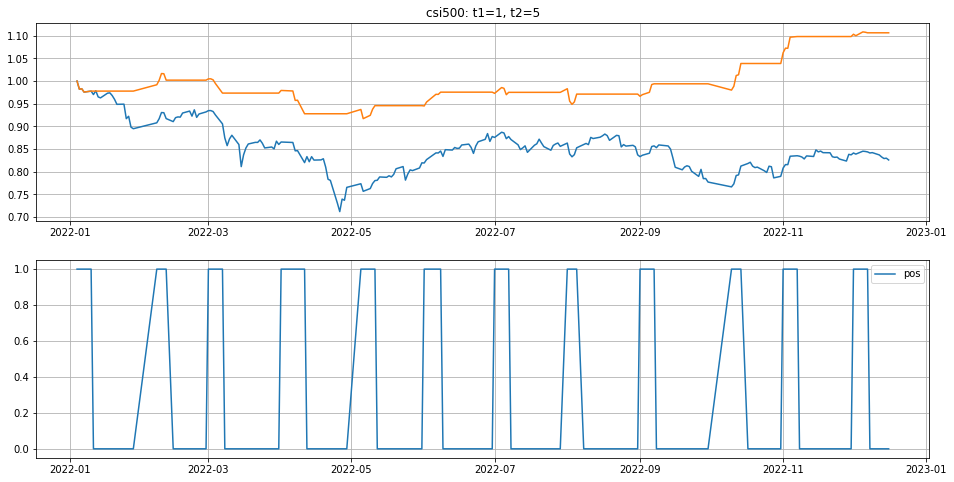

In [7]:
calendar_strategy(index_data, index_ids[1], start_date, end_date, [t1, t2], fee_rate_stock)

         AnnRet    AnnVol        SR     MaxDD    Calmar
index  -0.19044  0.250569 -0.760031 -0.340285 -0.559649
stgy   0.117351  0.114115  1.028358 -0.130048  0.902368


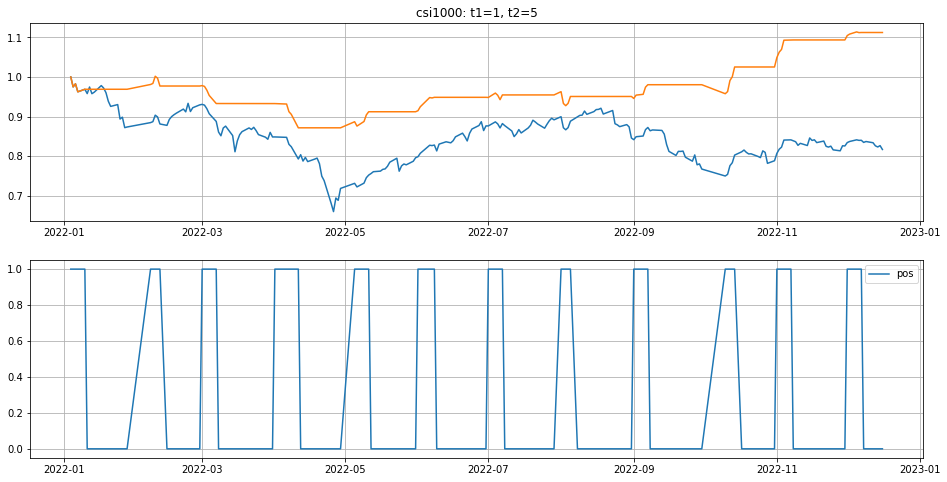

In [8]:
calendar_strategy(index_data, index_ids[2], start_date, end_date, [t1, t2], fee_rate_stock)

使用基金替代指数验证策略结果

In [9]:
# index_data = pd.read_csv('res/161017.csv').set_index('datetime')
index_data = pd.read_csv('res/160119.csv').set_index('datetime')
index_data.index = [datestr2dtdate(e) for e in index_data.index]

         AnnRet    AnnVol        SR     MaxDD    Calmar
index -0.144809  0.194119 -0.745979  -0.26113 -0.554546
stgy   0.088004  0.087137  1.009947 -0.091349   0.96338


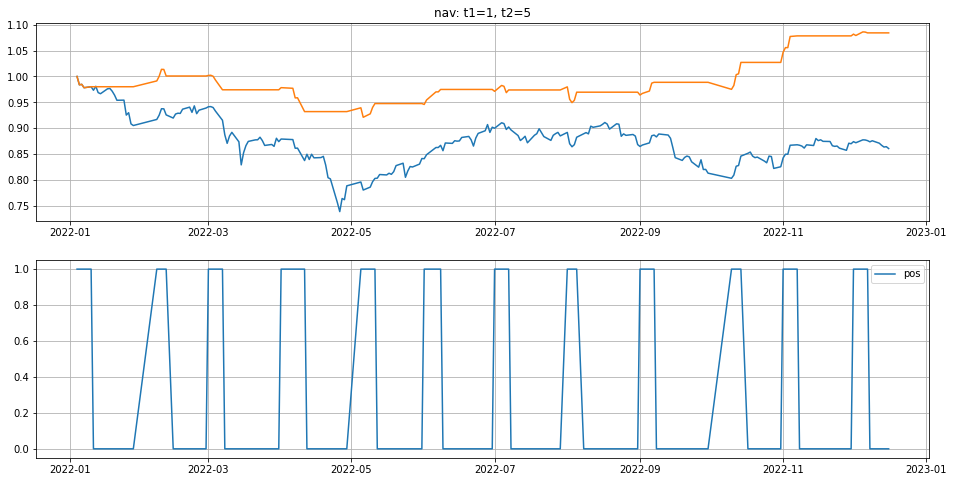

In [10]:
calendar_strategy(index_data, 'nav', start_date, end_date, [t1, t2], fee_rate_fund)

使用 ETF 替代指数验证策略结果

In [11]:
index_data = pd.read_csv('res/510500.csv').set_index('datetime')
index_data.index = [datestr2dtdate(e) for e in index_data.index]

         AnnRet    AnnVol        SR     MaxDD    Calmar
index -0.161107  0.216891 -0.742803 -0.287756 -0.559874
stgy   0.116816  0.097788  1.194585 -0.097741  1.195154


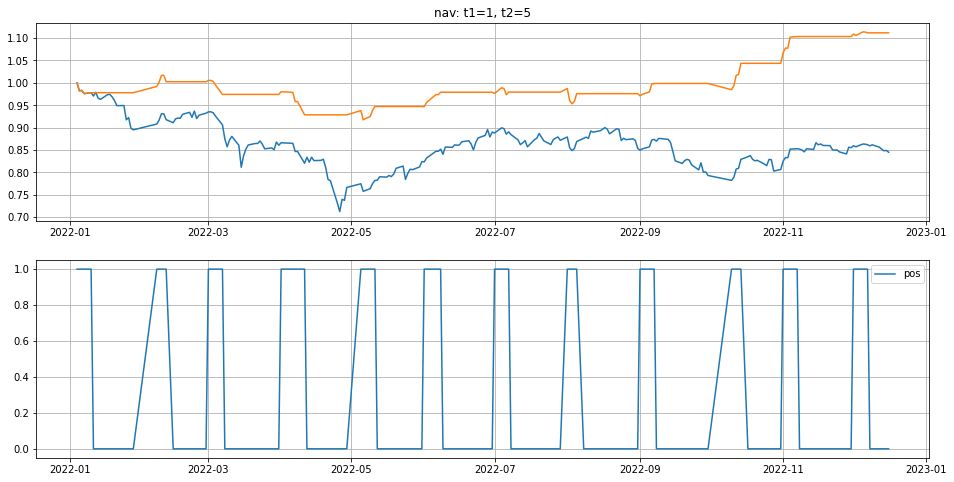

In [12]:
calendar_strategy(index_data, 'nav', start_date, end_date, [t1, t2], fee_rate_stock)